# 브런치 사용자를 위한 작가 및 글 추천
## 1팀 : AI Love You

In [2]:
import glob
import json
import os
import re
from collections import Counter
from datetime import timedelta, datetime
from itertools import chain
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import ast
#wordcloud 관련 패키지 import
from wordcloud import WordCloud
from PIL import Image # 만약 "No module named 'PIL'" 에러가 발생하면 [ pip install Pillow==5.4.1 ] 로 라이브러리를 설치해줍니다.
%matplotlib inline
from tqdm import trange, notebook

In [3]:
font_path = 'c:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font_name, size=12)
plt.rcParams["figure.figsize"] = (20, 10)
register_matplotlib_converters()

In [4]:
directory = 'D:\data/'

## 1. Data Read

### a. Magazine.json

In [4]:
magazine = pd.read_json(directory + 'magazine.json', lines=True)
# magazine = pd.read_excel('magazine.xlsx', index_col=0) #test용 100 size의 데이터 불러오기

In [5]:
magazine.head()

,magazine_tag_list,id
0,"[브런치북, 육아일기, 대화법, 들려주고픈이야기]",38842
1,"[tea, food]",11540
2,[food],11541
3,"[브런치북, 일상, 시, 사람]",11546
4,"[감성에세이, 노래, 음악에세이]",11544


In [6]:
magazine.shape

(27967, 2)

### b. Metadata.json

In [7]:
metadata = pd.read_json(directory + 'metadata.json', lines=True)
# metadata = pd.read_excel('metadata.xlsx', index_col=0) #test용 100 size의 데이터 불러오기

In [8]:
metadata.head()

,magazine_id,user_id,title,keyword_list,display_url,sub_title,reg_ts,article_id,id
0,8982,@bookdb,"사진으로 옮기기에도 아까운, 리치필드 국립공원","[여행, 호주, 국립공원]",https://brunch.co.kr/@bookdb/782,세상 어디에도 없는 호주 Top 10,1474944427000,782,@bookdb_782
1,12081,@kohwang56,[시] 서러운 봄,"[목련꽃, 아지랑이, 동행]",https://brunch.co.kr/@kohwang56/81,,1463092749000,81,@kohwang56_81
2,0,@hannahajink,무엇을 위해,[],https://brunch.co.kr/@hannahajink/4,무엇 때문에,1447997287000,4,@hannahajink_4
3,16315,@bryceandjuli,싫다,"[감정, 마음, 위로]",https://brunch.co.kr/@bryceandjuli/88,,1491055161000,88,@bryceandjuli_88
4,29363,@mijeongpark,Dubliner#7,"[유럽여행, 더블린, 아일랜드]",https://brunch.co.kr/@mijeongpark/34,#7. 내 친구의 집은 어디인가,1523292942000,34,@mijeongpark_34


In [9]:
metadata.shape

(643104, 9)

### c. Users.json

In [12]:
users_df = pd.read_json(directory + '/users.json', lines=True)
# users_df = pd.read_excel('users.xlsx', index_col=0) #test용 100 size의 데이터 불러오기

In [13]:
users_df.head()

,keyword_list,following_list,id
0,[],"[@perytail, @brunch]",#901985d8bc4c481805c4a4f911814c4a
1,[],"[@holidaymemories, @wadiz, @sciforus, @dailydu...",#1fd89e9dcfa64b45020d9eaca54e0eed
2,[],"[@commerceguy, @sunsutu, @kakao-it, @joohoonja...",#1d94baaea71a831e1f33e1c6bd126ed5
3,[],"[@amberjeon48, @forsy20, @nemotokki, @hawann, ...",#04641c01892b12dc018b1410e4928c0d
4,[],"[@dwcha7342, @iammento, @kakao-it, @dkam, @ant...",#65bcaff862aadff877e461f54187ab62


In [14]:
users_df.shape

(310758, 3)

### d. Read Files

In [15]:
# read_raw = pd.read_excel('read.xlsx') #test용 100 size의 데이터 불러오기
# read_raw.head()

In [16]:
# read_raw.shape

In [17]:
read_file_lst = glob.glob(directory+'read/*')

In [18]:
exclude_file_lst = ['read.tar']

In [19]:
read_df_lst = []
for f in read_file_lst:
    file_name = os.path.basename(f)
    if file_name in exclude_file_lst:
        print(file_name)
    else:
        df_temp = pd.read_csv(f, header=None, names=['raw'])
        df_temp['dt'] = file_name[:8]
        df_temp['hr'] = file_name[8:10]
        df_temp['user_id'] = df_temp['raw'].str.split(' ').str[0]
        df_temp['article_id'] = df_temp['raw'].str.split(' ').str[1:].str.join(' ').str.strip()
        read_df_lst.append(df_temp)

In [20]:
read = pd.concat(read_df_lst)

In [21]:
read.head()

,raw,dt,hr,user_id,article_id
0,#e208be4ffea19b1ceb5cea2e3c4dc32c @kty0613_91,20181001,00,#e208be4ffea19b1ceb5cea2e3c4dc32c,@kty0613_91
1,#0a3d493f3b2318be80f391eaa00bfd1c @miamiyoung_...,20181001,00,#0a3d493f3b2318be80f391eaa00bfd1c,@miamiyoung_31 @banksalad_49 @rlfrjsdn_95 @rea...
2,#b90d3ee7ed0d7d827aae168e159749f1 @joeunha_4 @...,20181001,00,#b90d3ee7ed0d7d827aae168e159749f1,@joeunha_4 @yoonvi_3
3,#b8b9d09fe2961fd62edc94912bf75a90 @hyejinchoi_...,20181001,00,#b8b9d09fe2961fd62edc94912bf75a90,@hyejinchoi_122 @hyejinchoi_86 @hyejinchoi_42 ...
4,#072f742eda9359cdac03ad080193c11d @doyeonsunim...,20181001,00,#072f742eda9359cdac03ad080193c11d,@doyeonsunim_240 @k52524_297 @bule13_33 @kwong...


#### 탐색하기 좋은 데이터 포맷으로 변경

In [22]:
def chainer(s):
    return list(chain.from_iterable(s.str.split(' ')))

In [23]:
read_cnt_by_user = read['article_id'].str.split(' ').map(len)

In [24]:
read_raw = pd.DataFrame({'dt': np.repeat(read['dt'], read_cnt_by_user),
                         'hr': np.repeat(read['hr'], read_cnt_by_user),
                         'user_id': np.repeat(read['user_id'], read_cnt_by_user),
                         'article_id': chainer(read['article_id'])})

In [25]:
read_raw.head()

,dt,hr,user_id,article_id
0,20181001,00,#e208be4ffea19b1ceb5cea2e3c4dc32c,@kty0613_91
1,20181001,00,#0a3d493f3b2318be80f391eaa00bfd1c,@miamiyoung_31
1,20181001,00,#0a3d493f3b2318be80f391eaa00bfd1c,@banksalad_49
1,20181001,00,#0a3d493f3b2318be80f391eaa00bfd1c,@rlfrjsdn_95
1,20181001,00,#0a3d493f3b2318be80f391eaa00bfd1c,@readme999_140


In [26]:
print("전체 데이터 건수:", read_raw.shape)
print("중복 소비를 제외한 데이터 건수:", read_raw[['user_id', 'article_id']].drop_duplicates().shape)
print("Unique 독자 수:", len(read_raw['user_id'].unique()))
print("소비된 Unique 글 수:", len(read_raw['article_id'].unique()))

전체 데이터 건수: (22110706, 4)
중복 소비를 제외한 데이터 건수: (12597878, 2)
Unique 독자 수: 306222
소비된 Unique 글 수: 505841


## 2.EDA

### 작가들이 쓴 키워드

In [29]:
#meta data의 총 키워드 갯수를 확인해 보는 과정
text_temp = []
for n in list(metadata['keyword_list']):
#     n = ast.literal_eval(n)
    for i in n:
        text_temp.append(i)

In [30]:
word_dic = {}

for word in text_temp:
    if word not in word_dic:
        word_dic[word] = 1 # changed from "0" to "1"
    else:
        word_dic[word] += 1
word_dic

{'여행': 33887,
 '호주': 1372,
 '국립공원': 164,
 '목련꽃': 22,
 '아지랑이': 9,
 '동행': 107,
 '감정': 2468,
 '마음': 7030,
 '위로': 2101,
 '유럽여행': 5558,
 '더블린': 184,
 '아일랜드': 399,
 '석유에너지': 4,
 '베네수엘라': 50,
 '경제': 1299,
 '입찰': 47,
 '유치권': 13,
 '부동산경매변호사': 1,
 '사랑': 25177,
 '연애': 7819,
 'rain': 33,
 '메일': 83,
 '출판사': 225,
 '도시애벌레': 1,
 '공부': 2459,
 '동시': 163,
 '패션': 1541,
 '에세이': 17629,
 '불꽃축제': 37,
 '불꽃': 62,
 '여의도': 55,
 '주머니': 34,
 '빵가게': 8,
 '생각': 14254,
 '과거': 435,
 '무시': 50,
 '단상': 460,
 '시험': 462,
 '아침조회시간': 1,
 '감성에세이': 10021,
 '첫사랑': 381,
 '애견놀이터': 1,
 '애견': 31,
 '애견카페': 9,
 '엄마': 6404,
 '취향': 638,
 '효도': 88,
 '칼국수': 60,
 '대화': 1458,
 '저항': 73,
 '세계여행': 3444,
 '행복': 8472,
 '버스': 675,
 '지하철': 669,
 '친구': 3959,
 '그림자': 264,
 '하이에나': 4,
 '도시': 787,
 '자작소설': 24,
 '창작': 302,
 '팀워크': 27,
 '성과': 208,
 '개인기': 3,
 '브랜드': 1941,
 '브랜딩': 790,
 '마케팅': 5145,
 '일자리': 298,
 '청년실업': 58,
 '저출산': 102,
 '취업': 3783,
 '사회생활': 385,
 '결혼': 4000,
 '장애엄마': 5,
 '부모교육': 195,
 '새학기': 27,
 '젠트리피케이션': 74,
 '주거문화': 7,
 '서울': 1295,

In [31]:
sorted_word_dic = sorted(word_dic.items(), key=lambda x:x[1], reverse=True)
sorted_word_dic[:5]

[('여행', 33887), ('영화', 27058), ('사랑', 25177), ('에세이', 17629), ('그림일기', 15806)]

### 작가들이 많이 사용한 키워드의 워드 맵

In [32]:
word_cloud = WordCloud(font_path="C:/Windows/Fonts/malgun.ttf",
                       max_words=50, width=2000, height=1000,prefer_horizontal= 1.0,
                       background_color='white')

In [33]:
word_cloud.generate_from_frequencies(word_dic)

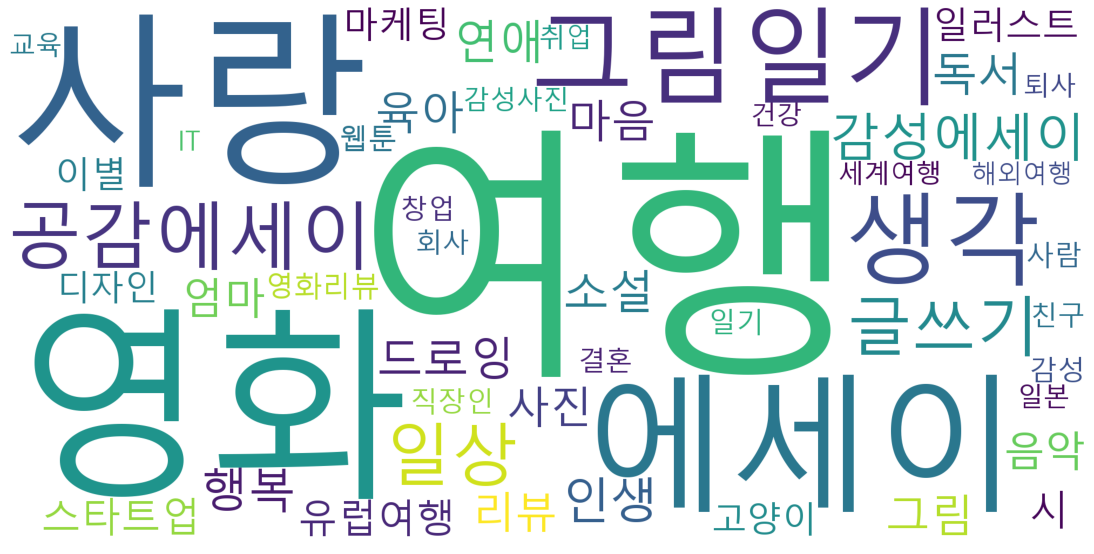

In [34]:
plt.figure(figsize=(15,15)) 
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show() #작가들이 많이 사용한 키워드의 워드 맵

### 독자들이 팔로우한 작가들의 키워드리스트

In [5]:
#독자 데이터 불러오기 #독자 데이터 생성은 아래에서 소개
user_keyword = pd.read_excel('user_keyword.xlsx')
user_keyword.head()

,user_id,keyword_list
0,#00001ba6ca8d87d2fc34d626ba9cfe6f,"['사랑', '성공', '인생', '브런치', '작가', '글쓰기', '해외취업',..."
1,#0000e87158c1426d6ffb72cebac6cb64,"['브런치', '가해자', '여성혐오', '페미니스트']"
2,#0000eea6d339abfd02ed590bc451fc63,"['인간관계', '해외생활', '회사']"
3,#0000fdba8f35c76eacab74c5c6bc7f1a,"['도쿄', '여행', '그림에세이', '도쿄', '여행', '그림에세이', '운동..."
4,#000127ad0f1981cae1292efdb228f0e9,"['사랑', '결혼', '결혼생활', '사랑', '결혼', '결혼생활', '연애',..."


In [6]:
text_temp = []
for n in list(user_keyword['keyword_list']):
    n = ast.literal_eval(n)
    for i in n:
        text_temp.append(i)

In [7]:
word_dic = {}

for word in text_temp:
    if word not in word_dic:
        word_dic[word] = 1 # changed from "0" to "1"
    else:
        word_dic[word] += 1
sorted_word_dic = sorted(word_dic.items(), key=lambda x:x[1], reverse=True)
sorted_word_dic

[('사랑', 160),
 ('연애', 141),
 ('공감에세이', 125),
 ('에세이', 116),
 ('결혼', 104),
 ('여행', 94),
 ('영화', 86),
 ('브런치', 85),
 ('그림일기', 78),
 ('작가', 71),
 ('스타트업', 70),
 ('운동', 64),
 ('마케팅', 57),
 ('건강', 56),
 ('생각', 55),
 ('다이어트', 54),
 ('심리', 53),
 ('시어머니', 49),
 ('육아', 48),
 ('디자인', 48),
 ('직장인', 48),
 ('드로잉', 48),
 ('글쓰기', 45),
 ('출판', 42),
 ('행복', 41),
 ('인생', 40),
 ('일러스트', 38),
 ('엄마', 36),
 ('일상', 35),
 ('디자이너', 34),
 ('며느리', 33),
 ('감성에세이', 30),
 ('요가', 29),
 ('영화리뷰', 29),
 ('심리상담', 28),
 ('소설', 28),
 ('브런치X빨강머리앤', 27),
 ('퇴사', 27),
 ('취업', 27),
 ('재테크', 27),
 ('회사', 25),
 ('빨강머리앤', 25),
 ('패스트파이브', 25),
 ('독일', 24),
 ('성공', 23),
 ('투자', 23),
 ('일상에세이', 23),
 ('경제', 23),
 ('인간관계', 22),
 ('IT', 22),
 ('캘리그라피', 22),
 ('독서', 22),
 ('좋은글', 22),
 ('고양이', 22),
 ('감성사진', 22),
 ('자기계발', 22),
 ('그림', 22),
 ('영어공부', 22),
 ('시', 22),
 ('공감', 21),
 ('결혼생활', 21),
 ('요리', 21),
 ('법륜스님', 21),
 ('스트레스', 20),
 ('유럽여행', 20),
 ('주식', 20),
 ('브런치무비패스', 19),
 ('게임', 19),
 ('콘텐츠', 19),
 ('직장', 18),
 ('공부', 18)

In [8]:
word_cloud = WordCloud(font_path="C:/Windows/Fonts/malgun.ttf",
                       max_words=50, width=2000, height=1000,
                       background_color='white',prefer_horizontal= 1.0)
word_cloud.generate_from_frequencies(word_dic)


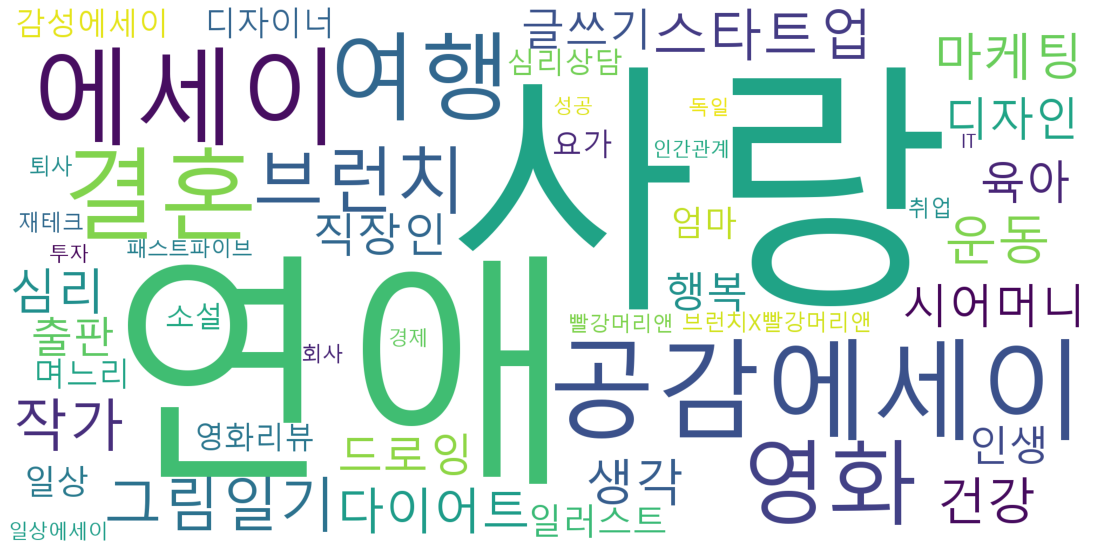

In [9]:
plt.figure(figsize=(15,15)) 
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show() #독자들이 관심있어하는  키워드의 워드 맵

## 3. New Data set

### a. writer top 4000's list

In [40]:
#글을 많이 쓴 작가 4000명
writer = metadata.copy()
writer_count = writer['user_id'].value_counts()
writer_4000 = writer_count.head(4000)
writer_4000 = pd.DataFrame(writer_4000)
writer_4000 = writer_4000.reset_index()
writer_4000.columns = ['writer_id', 'page_num']
writer_4000

,writer_id,page_num
0,@bookfit,4106
1,@wikitree,3192
2,@jordan777,2797
3,@hitchwill,2115
4,@tenbody,1759
...,...,...
3995,@silsill,39
3996,@tanker1231,39
3997,@prague,39
3998,@leeheesun,39


### b. writer top 4000's keyword

In [47]:
#작가별 keyword 목록 나열
keyword_list = []
for i in notebook.tqdm(range(len(writer_4000['writer_id']))):
    temp = []
    keywords = metadata[metadata['user_id'] == writer_4000['writer_id'][i]]['keyword_list']
    for keyword in keywords:
#         keyword = ast.literal_eval(keyword)
        for i in keyword:
            temp.append(i)
    keyword_list.append(temp)
writer_4000['keyword_list'] = keyword_list

  0%|          | 0/4000 [00:00<?, ?it/s]

In [48]:
writer_4000

,writer_id,page_num,keyword_list
0,@bookfit,4106,"[창업, 비즈니스, 문제, 경제, 살림살이, 경제학, 미세먼지, 날씨, 자연, 건축..."
1,@wikitree,3192,"[지휘관, 장교, 청계천, 서울, IT, 번호, 중소기업, 제네시스그룹, 미국해변,..."
2,@jordan777,2797,"[석유에너지, 베네수엘라, 경제, 일자리, 청년실업, 저출산, 플레이, 보이, 적자..."
3,@hitchwill,2115,"[국내여행, 한옥, 청양, 여행, 가을, 코스모스, 감귤농장, 제주감귤, 감귤, 제..."
4,@tenbody,1759,"[운동, 근육, 다이어트, 운동, 뱃살, 다이어트, 운동, 허리, 스트레칭, 스트레..."
...,...,...,...
3995,@silsill,39,"[아일랜드, 여행, 불편, 생각, 젊음, 권태, 영화, 음악, 노래, 윤종신, 노래..."
3996,@tanker1231,39,"[그림, 일기, 미술, 믿음, 신앙생활, 기독교, 설교, 일기, 이사, 시작, 연애..."
3997,@prague,39,"[프라하, 유럽여행, 체코, 유럽여행, 프라하, 체코, 프라하, 유럽여행, 체코여행..."
3998,@leeheesun,39,"[그리움, 사랑, 솔로, 봄, 에피톤프로젝트, 노래, 유럽여행, 치즈, 배낭여행, ..."


In [57]:
#작가별 top n 키워드 추출함수
def get_author_keyword(keyword_num):
    top_keyword= []
    for i in notebook.tqdm(range(len(writer_4000['writer_id']))):
        temp = {}

        keywords = metadata.loc[metadata['user_id'] == writer_4000['writer_id'][i], 'keywords']
        for keyword in keywords:
#             keyword = ast.literal_eval(keyword)
            for i in keyword:
                if i in temp:
                    temp[i] += 1
                else:
                    temp[i] = 1
        temp = sorted(temp.items(), key=lambda x:x[1], reverse=True)
        temp_2 = []
        
        for i in range(len(temp[:keyword_num])):
            temp_2.append(temp[i][0])
        top_keyword.append(temp_2)
    return top_keyword

In [52]:
top20 = get_author_keyword(20) #top20 keyword 추출
writer_4000['keyword_list_20'] = top20

In [53]:
writer_4000 = writer_4000[['writer_id','page_num','keyword_list','keyword_list_20']]
# writer_4000 = writer_4000[['writer_id','page_num','keyword_list','keyword_list_20','keywords']]
writer_4000.head()

,writer_id,page_num,keyword_list,keyword_list_20
0,@bookfit,4106,"[창업, 비즈니스, 문제, 경제, 살림살이, 경제학, 미세먼지, 날씨, 자연, 건축...","[성공, 행복, 인생, 부동산, 여행, 창업, 사랑, 생각, 인간관계, 교육, 독서..."
1,@wikitree,3192,"[지휘관, 장교, 청계천, 서울, IT, 번호, 중소기업, 제네시스그룹, 미국해변,...","[영화, 뉴스, 연합뉴스, 경찰, 다이어트, 사진, 여행, 박근혜, 맥주, 현대자동..."
2,@jordan777,2797,"[석유에너지, 베네수엘라, 경제, 일자리, 청년실업, 저출산, 플레이, 보이, 적자...","[중국, 미국, 트럼프, 부동산, 주식, 투자, 구글, 아파트, 애플, 일본, 아마..."
3,@hitchwill,2115,"[국내여행, 한옥, 청양, 여행, 가을, 코스모스, 감귤농장, 제주감귤, 감귤, 제...","[국내여행, 영화, 여행, 여행정보, 음식, 사랑, 소설, 일본, 관광, 문경, 브..."
4,@tenbody,1759,"[운동, 근육, 다이어트, 운동, 뱃살, 다이어트, 운동, 허리, 스트레칭, 스트레...","[다이어트, 운동, 건강, 스트레칭, 근육, 뱃살, 요가, 음식, 복근, 하체운동,..."


In [54]:
writer_4000.to_csv(directory+"writer_4000(most20 keyword, keywords).csv") #csv 파일로 저장

### c. user keyword data

In [63]:
writer_4000 = pd.read_csv(directory+'writer_4000most3_keyword_keywords.csv', index_col = 'Unnamed: 0')
writer_4000

,writer_id,page_num,keyword_list,keywords
0,@bookfit,4106,"['성공', '행복', '인생']","['창업', '비즈니스', '문제', '경제', '살림살이', '경제학', '미세먼..."
1,@wikitree,3192,"['영화', '뉴스', '연합뉴스']","['지휘관', '장교', '청계천', '서울', 'IT', '번호', '중소기업',..."
2,@jordan777,2797,"['중국', '미국', '트럼프']","['석유에너지', '베네수엘라', '경제', '일자리', '청년실업', '저출산',..."
3,@hitchwill,2115,"['국내여행', '영화', '여행']","['국내여행', '한옥', '청양', '여행', '가을', '코스모스', '감귤농장..."
4,@tenbody,1759,"['다이어트', '운동', '건강']","['운동', '근육', '다이어트', '운동', '뱃살', '다이어트', '운동',..."
...,...,...,...,...
3995,@starshines,39,"['영화', '사랑', '전쟁']","['영화', '저니스엔드', '전쟁', '영화', '하정우', '민주주의', '히트..."
3996,@jeolmiing,39,"['독서', '독서모임', '인터뷰']","['독서', '일상', '인터뷰', '후기', '독서모임', '가이드', '인터뷰'..."
3997,@prague,39,"['프라하', '체코', '유럽여행']","['프라하', '유럽여행', '체코', '유럽여행', '프라하', '체코', '프라..."
3998,@tilltue,39,"['IT', 'iOS', '개발']","['테스트코드', '테스트', 'IT', 'IT', 'iOS', 'IT', '테스트..."


In [56]:
# following_list가 있는 유저
following = users_df[users_df['following_list'].str.len() !=0 ]

In [57]:
following = following[['id', 'following_list']]
following

,id,following_list
0,#901985d8bc4c481805c4a4f911814c4a,"[@perytail, @brunch]"
1,#1fd89e9dcfa64b45020d9eaca54e0eed,"[@holidaymemories, @wadiz, @sciforus, @dailydu..."
2,#1d94baaea71a831e1f33e1c6bd126ed5,"[@commerceguy, @sunsutu, @kakao-it, @joohoonja..."
3,#04641c01892b12dc018b1410e4928c0d,"[@amberjeon48, @forsy20, @nemotokki, @hawann, ..."
4,#65bcaff862aadff877e461f54187ab62,"[@dwcha7342, @iammento, @kakao-it, @dkam, @ant..."
...,...,...
310752,#6b7a58c1002fe2763bf4db6e223769b1,"[@angiesongc9sx, @merryseo, @psychiatricnews, ..."
310753,#2863e47d50f1640df6dac10b7bad94fb,"[@login002, @kkonal, @leeraha, @tobeme, @sohyu..."
310754,#4341a155d1966e5618e310c45386aea4,"[@simplelife-1p, @mint5051, @thecapitalist, @s..."
310755,#0d70f397a78d2ef638f812592fa8e6ba,"[@cometseeker, @bijou, @suhanjang, @brunch]"


In [59]:
def get_user_following_author_keywords(id):
    temp = []
    follow_list = list(following.loc[following['id'] == id, 'following_list'])[0]
    for author in follow_list:
        append_list = writer_4000.loc[writer_4000['writer_id'] == author, 'keywords']
        if len(append_list) > 0:
            append_list = list(append_list)[0]
            temp.append(append_list)

    result = temp[0]
    for i in range(1,len(temp)):
        result += temp[i]
    return result

In [37]:
temp = get_user_following_author_keywords('#901985d8bc4c481805c4a4f911814c4a')
test = temp[1:-1].split(', ')

In [38]:
test

["'그림일기'",
 "'부산외대컴퓨터수리'",
 "'현진컴퓨터'",
 "'모험'",
 "'희극'",
 "'비극'",
 "'로건'",
 "'울버린'",
 "'엑스맨'",
 "'Instagram'",
 "'무책임'",
 "'페리'",
 "'에너지'",
 "'거절'",
 "'실패'",
 "'오라'",
 "'당신'",
 "'하늘'",
 "'슬픔'",
 "'생각'",
 "'당신'",
 "'비가'",
 "'당신'",
 "'본격광고만화'",
 "'토스터'",
 "'기억'",
 "'햇살'",
 "'바닥'",
 "'초록'",
 "'당신'",
 "'제주'",
 "'협재바다'",
 "'바다'",
 "'꼬옥'",
 "'그늘'",
 "'평생'",
 "'햇살'",
 "'시간'",
 "'새해'",
 "'세상'",
 "'항해'",
 "'햇살'",
 "'바다'",
 "'겨울'",
 "'당신'",
 "'행복'",
 "'매일'",
 "'로켓'",
 "'행복'",
 "'잠금화면'",
 "'온도'",
 "'화면'",
 "'웃음'",
 "'비결'",
 "'기분'",
 "'꽃길'",
 "'걸음'",
 "'당신'",
 "'페리'",
 "'제주'",
 "'시작'",
 "'시간'",
 "'페리'",
 "'제주동쪽'",
 "'제주'",
 "'풍림다방'",
 "'제주'",
 "'협재'",
 "'미니'",
 "'금빛'",
 "'순간'",
 "'당신'",
 "'조각'",
 "'욕심'",
 "'마음'",
 "'유리'",
 "'당신'",
 "'생각'",
 "'페리'",
 "'이모티콘'",
 "'자가증식'",
 "'영화'",
 "'라라랜드'",
 "'공중'",
 "'BMW'",
 "'페리'",
 "'메일'",
 "'손짓'",
 "'바닥'",
 "'점점'",
 "'메리크리스마스'",
 "'크리스마스'",
 "'당신'",
 "'안녕'",
 "'당신'",
 "'다음'",
 "'페리'",
 "'여행'",
 "'출발'",
 "'순간'",
 "'페리'",
 "'페리'",
 "'부탁'",
 "'올해'",
 "'버프툰'",
 "'

# 유사도 분석

## 4. TF-IDF

### a. user_keyword.xlsx

In [11]:
user = pd.read_excel(directory+'user_keyword.xlsx')

In [65]:
user.head()

,user_id,keyword_list
0,#00001ba6ca8d87d2fc34d626ba9cfe6f,"[사랑, 성공, 인생, 브런치, 작가, 글쓰기, 해외취업, 취직, 싱가포르]"
1,#0000e87158c1426d6ffb72cebac6cb64,"[브런치, 가해자, 여성혐오, 페미니스트]"
2,#0000eea6d339abfd02ed590bc451fc63,"['인간관계', '해외생활', '회사']"
3,#0000fdba8f35c76eacab74c5c6bc7f1a,"['도쿄', '여행', '그림에세이', '도쿄', '여행', '그림에세이', '운동..."
4,#000127ad0f1981cae1292efdb228f0e9,"['사랑', '결혼', '결혼생활', '사랑', '결혼', '결혼생활', '연애',..."


### b. writer.xlsx

In [17]:
writer_4000 = pd.read_csv(directory+'writer_4000(most20 keyword, keywords).csv', index_col=0)

In [18]:
writer_4000.head()

,writer_id,page_num,keyword_list,keyword_list_20
0,@bookfit,4106,"['창업', '비즈니스', '문제', '경제', '살림살이', '경제학', '미세먼...","['성공', '행복', '인생', '부동산', '여행', '창업', '사랑', '생..."
1,@wikitree,3192,"['지휘관', '장교', '청계천', '서울', 'IT', '번호', '중소기업',...","['영화', '뉴스', '연합뉴스', '경찰', '다이어트', '사진', '여행',..."
2,@jordan777,2797,"['석유에너지', '베네수엘라', '경제', '일자리', '청년실업', '저출산',...","['중국', '미국', '트럼프', '부동산', '주식', '투자', '구글', '..."
3,@hitchwill,2115,"['국내여행', '한옥', '청양', '여행', '가을', '코스모스', '감귤농장...","['국내여행', '영화', '여행', '여행정보', '음식', '사랑', '소설',..."
4,@tenbody,1759,"['운동', '근육', '다이어트', '운동', '뱃살', '다이어트', '운동',...","['다이어트', '운동', '건강', '스트레칭', '근육', '뱃살', '요가',..."


### c. users.json

In [21]:
users_follow = pd.read_json(directory+'users.json', lines=True)

In [22]:
# following_list가 있는 유저
following = users_follow[users_follow['following_list'].str.len() !=0 ]
following = following[['id', 'following_list']]
following

,id,following_list
0,#901985d8bc4c481805c4a4f911814c4a,"[@perytail, @brunch]"
1,#1fd89e9dcfa64b45020d9eaca54e0eed,"[@holidaymemories, @wadiz, @sciforus, @dailydu..."
2,#1d94baaea71a831e1f33e1c6bd126ed5,"[@commerceguy, @sunsutu, @kakao-it, @joohoonja..."
3,#04641c01892b12dc018b1410e4928c0d,"[@amberjeon48, @forsy20, @nemotokki, @hawann, ..."
4,#65bcaff862aadff877e461f54187ab62,"[@dwcha7342, @iammento, @kakao-it, @dkam, @ant..."
...,...,...
310752,#6b7a58c1002fe2763bf4db6e223769b1,"[@angiesongc9sx, @merryseo, @psychiatricnews, ..."
310753,#2863e47d50f1640df6dac10b7bad94fb,"[@login002, @kkonal, @leeraha, @tobeme, @sohyu..."
310754,#4341a155d1966e5618e310c45386aea4,"[@simplelife-1p, @mint5051, @thecapitalist, @s..."
310755,#0d70f397a78d2ef638f812592fa8e6ba,"[@cometseeker, @bijou, @suhanjang, @brunch]"


### d. TF-IDF & cosine_similarity

### 독자가 읽은 글 기반

In [52]:
writer_4000 = pd.read_csv(directory + 'writer_4000most3_keyword_keywords.csv', index_col=0)
# 작가 데이터 vectorization
writer_key = []

for i in range(4000):
    writer_key.append(' '.join(eval(writer_4000['keyword_list'][i])))
    
corpus = writer_key
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus).todense()
pd.DataFrame(X)


def reader_read(i):    
    # 독자데이터 vectorization
    read_key = user['keyword_list']
    read_key[i] = eval(read_key[i])
    read1 = ' '.join(read_key[i])
    reader = vectorizer.transform([read1]).todense()
    
    # Cosine similarity 계산
    cosine_similarity(reader, X)
    result = cosine_similarity(reader, X)
    
    # 결과 값 도출
    global writer_4000
    writer_4000['read_sim'] = result[0]
    writer_4000.sort_values(by='read_sim', ascending=False)
    writer_4000 = writer_4000.sort_values(by='read_sim', ascending=False)
    writer_top3 = writer_4000.head(3)
    writer_results = writer_top3['writer_id'].tolist()
    print("%s님께 추천드리는 작가는 %s, %s, %s 입니다."%(user['user_id'][i], writer_results[0], writer_results[1], writer_results[2]))


In [53]:
reader_read(1)

#0000e87158c1426d6ffb72cebac6cb64님께 추천드리는 작가는 @goodwriting, @endforand-do, @metamon 입니다.


### 독자가 구독한 작가 기반 계산

In [54]:
user['user_id'][1]

'#0000e87158c1426d6ffb72cebac6cb64'

In [60]:
def reader_follow(i):
    global writer_4000

    # 독자데이터 vectorization
    list_t = get_user_following_author_keywords(following['id'][i])
    read_to_list = [l + "]" for l in list_t.split("]")][:-1]
    read_to_list = [eval(l) for l in read_to_list]
    read2 =  ' '.join(read_to_list[0])
    reader2 = vectorizer.transform([read2]).todense()

    # Cosine similarity 계산
    result_follow = cosine_similarity(reader2, X)

    # 결과 값 도출
    writer_4000['follow_sim'] = result_follow[0]
    writer_4000 = writer_4000.sort_values(by='follow_sim', ascending=False)
    writers_top3 = writer_4000.head(3)
    writers_results = writers_top3['writer_id'].tolist()
    print("%s님께서 팔로우하시는 작가 기반으로 추천드리는 작가는 %s, %s, %s 입니다."%(user['user_id'][i], writers_results[0], writers_results[1], writers_results[2]))

In [61]:
reader_follow(1)

#0000e87158c1426d6ffb72cebac6cb64님께서 팔로우하시는 작가 기반으로 추천드리는 작가는 @quilty, @njj0772, @sshong 입니다.
